# Using NBA data from 2000-2019 seasons and putting all of these NBA players into cluster ranged 1-5

## 1: Superstar
## 2: High Level Starter/All Star
## 3: Solid Rotation Player
## 4: Bench/Roleplayer/ok impact
## 5: Bust/Min impact

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

player_stats = pd.read_csv("NBATestGrouped.csv")



print(f"Players after filtering: {len(player_stats)}")
print(player_stats.head())

Players after filtering: 736
         PLAYER         GP        MIN        PTS   REB       AST   STL  \
0   A.J. Lawson  34.000000  13.050000   6.150000  2.25  0.850000  0.35   
1      AJ Green  54.666667  14.533333   5.433333  1.60  0.866667  0.30   
2    AJ Griffin  46.000000  14.000000   5.650000  1.50  0.650000  0.35   
3    AJ Johnson  29.000000  22.000000   7.600000  2.00  2.600000  0.40   
4  Aaron Gordon  63.400000  29.900000  14.460000  5.90  3.080000  0.68   

        BLK    FG_PCT  FG3_PCT    FT_PCT       TOV  
0  0.150000  0.433500   0.2935  0.667500  0.450000  
1  0.066667  0.425333   0.4180  0.903333  0.333333  
2  0.150000  0.377500   0.3230  0.947000  0.500000  
3  0.100000  0.385000   0.2670  0.865000  1.200000  
4  0.600000  0.526800   0.3486  0.694000  1.580000  


# Finding features to be used for Clustering

In [14]:
# We want to use the most notable features for NBA players, maybe use weighted features in future
clustering_features = [
    'MIN',
    'PTS',
    'REB',
    'AST',
    'STL',
    'BLK',
    'FG_PCT',
    'FG3_PCT',
    'TOV'
]

X = player_stats[clustering_features].copy()

X['FG3_PCT'].fillna(0, inplace=True)
X.fillna(X.mean(), inplace=True)

print(X.describe())

              MIN         PTS         REB         AST         STL         BLK  \
count  736.000000  736.000000  736.000000  736.000000  736.000000  736.000000   
mean    19.472783    8.552776    3.506551    1.950598    0.619038    0.397301   
std      7.905628    5.680053    2.112318    1.628054    0.330047    0.377903   
min      3.000000    1.100000    0.300000    0.000000    0.000000    0.000000   
25%     13.300000    4.650000    1.945833    0.850000    0.400000    0.150000   
50%     18.750000    7.100000    3.050000    1.400000    0.575000    0.300000   
75%     25.250000   10.518750    4.340000    2.421250    0.800000    0.500000   
max     36.620000   31.725000   12.800000   10.340000    1.700000    3.700000   

           FG_PCT     FG3_PCT         TOV  
count  736.000000  736.000000  736.000000  
mean     0.454894    0.314846    1.049681  
std      0.074935    0.094778    0.707471  
min      0.220667    0.000000    0.000000  
25%      0.411300    0.295875    0.550000  
50%   

/var/folders/5h/_7p0899150l8hd4khcp86lf00000gn/T/ipykernel_56146/1628976822.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['FG3_PCT'].fillna(0, inplace=True)


# Standardizing Features selcted

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")

Scaled data shape: (736, 9)


# Finding what the optimal Number of Clusters are

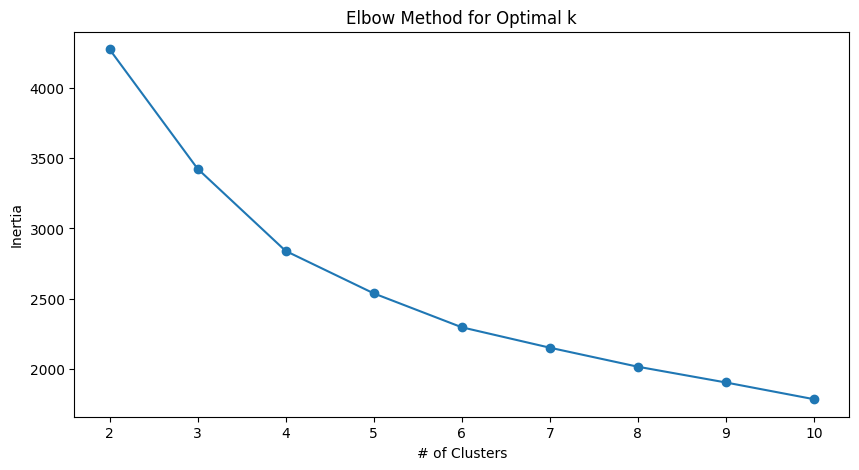

In [16]:
inertias = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Using K-means Clustering Algorithm

In [17]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20)
player_stats['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nCluster distribution:")
print(player_stats['Cluster'].value_counts().sort_index())


Cluster distribution:
Cluster
0     95
1    265
2     41
3     68
4    267
Name: count, dtype: int64


In [18]:
# First we are analyzing each cluster averages with points, minutes, and efficency rating.
# Then we are ranking the clusters from highest to lowest scoring
# Then we are re mapping the clusters so we can organzie from highest to lowest scoring to verify the superstars
# get placed in the right clusters.
# In the past we were getting a mixture of bad players in superstar categories because the features arn't being weighted by anything

player_stats['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = player_stats.groupby('Cluster')[clustering_features].mean()
print("\nCluster Performance: ")
print(cluster_summary[['PTS', 'MIN']].sort_values('PTS', ascending=False))

cluster_avg_pts = player_stats.groupby('Cluster')['PTS'].mean().sort_values(ascending=False)
print("\nClusters ranked by average PTS:")
print(cluster_avg_pts)

cluster_rank_mapping = {
    old_cluster: new_rank
    for new_rank, old_cluster in enumerate(cluster_avg_pts.index)
}

print("\nCluster mapping:")
print(cluster_rank_mapping)

player_stats['Cluster'] = player_stats['Cluster'].map(cluster_rank_mapping)

cluster_labels = {
    0: 'Superstar',
    1: 'All-Star/Starter',
    2: 'Role Player',
    3: 'Bench',
    4: 'Bust'
}

player_stats['Cluster_Label'] = player_stats['Cluster'].map(cluster_labels)

print("\n" + "="*60)
print("AFTER RELABELING:")
print("="*60)
for i in range(5):
    print(f"\n=== Cluster {i}: {cluster_labels[i]} ===")
    cluster_players = player_stats[player_stats['Cluster'] == i].sort_values('PTS', ascending=False)
    print(cluster_players[['PLAYER', 'PTS', 'MIN']].head(10))


Cluster Performance: 
               PTS        MIN
Cluster                      
0        19.221333  32.036439
2        12.140691  25.979228
4         9.119638  22.370162
3         5.254044  14.045074
1         4.448415  12.435698

Clusters ranked by average PTS:
Cluster
0    19.221333
2    12.140691
4     9.119638
3     5.254044
1     4.448415
Name: PTS, dtype: float64

Cluster mapping:
{0: 0, 2: 1, 4: 2, 3: 3, 1: 4}

AFTER RELABELING:

=== Cluster 0: Superstar ===
                      PLAYER     PTS     MIN
351              Joel Embiid  31.725  33.275
469              Luka Dončić  30.120  35.760
238    Giannis Antetokounmpo  29.980  33.480
633  Shai Gilgeous-Alexander  28.480  34.420
426             Kevin Durant  27.920  35.920
645            Stephen Curry  27.560  33.660
334             Jayson Tatum  27.420  36.140
460             LeBron James  26.860  35.260
138           Damian Lillard  26.840  35.980
544             Nikola Jokić  26.800  34.620

=== Cluster 1: All-Star/Starter

# Analyzing Clusters

In [19]:
cluster_summary = player_stats.groupby('Cluster')[clustering_features].mean()
print("\nCluster Characteristics:")
print(cluster_summary.round(2))

for i in range(5):
    print(f"\n=== Cluster {i} ===")
    cluster_players = player_stats[player_stats['Cluster'] == i].sort_values('PTS', ascending=False)
    print(cluster_players[['PLAYER', 'PTS', 'MIN']].head(10))


Cluster Characteristics:
           MIN    PTS   REB   AST   STL   BLK  FG_PCT  FG3_PCT   TOV
Cluster                                                             
0        32.04  19.22  5.35  5.19  1.08  0.48    0.46     0.35  2.45
1        25.98  12.14  8.28  1.75  0.74  1.43    0.57     0.19  1.43
2        22.37   9.12  3.59  2.11  0.75  0.38    0.45     0.35  1.08
3        14.05   5.25  4.15  0.76  0.34  0.60    0.58     0.17  0.71
4        12.44   4.45  1.86  0.97  0.37  0.17    0.41     0.32  0.54

=== Cluster 0 ===
                      PLAYER     PTS     MIN
351              Joel Embiid  31.725  33.275
469              Luka Dončić  30.120  35.760
238    Giannis Antetokounmpo  29.980  33.480
633  Shai Gilgeous-Alexander  28.480  34.420
426             Kevin Durant  27.920  35.920
645            Stephen Curry  27.560  33.660
334             Jayson Tatum  27.420  36.140
460             LeBron James  26.860  35.260
138           Damian Lillard  26.840  35.980
544             Nikola

In [20]:
cluster_labels = {
    0: 'Superstar',
    1: 'All-Star/Starter',
    2: 'Role Player',
    3: 'Bench',
    4: 'Bust'
}

player_stats['Cluster_Label'] = player_stats['Cluster'].map(cluster_labels)

print("\nFinal Cluster Distribution:")
print(player_stats['Cluster_Label'].value_counts())

player_stats.to_csv("NBATestClustered.csv", index=False)


Final Cluster Distribution:
Cluster_Label
Role Player         267
Bust                265
Superstar            95
Bench                68
All-Star/Starter     41
Name: count, dtype: int64


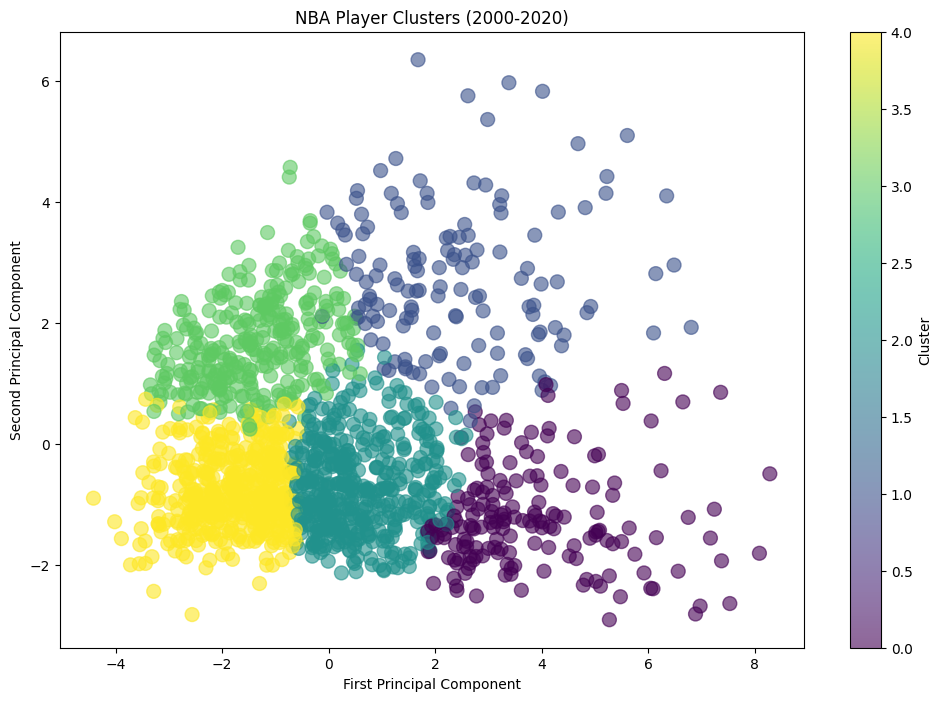

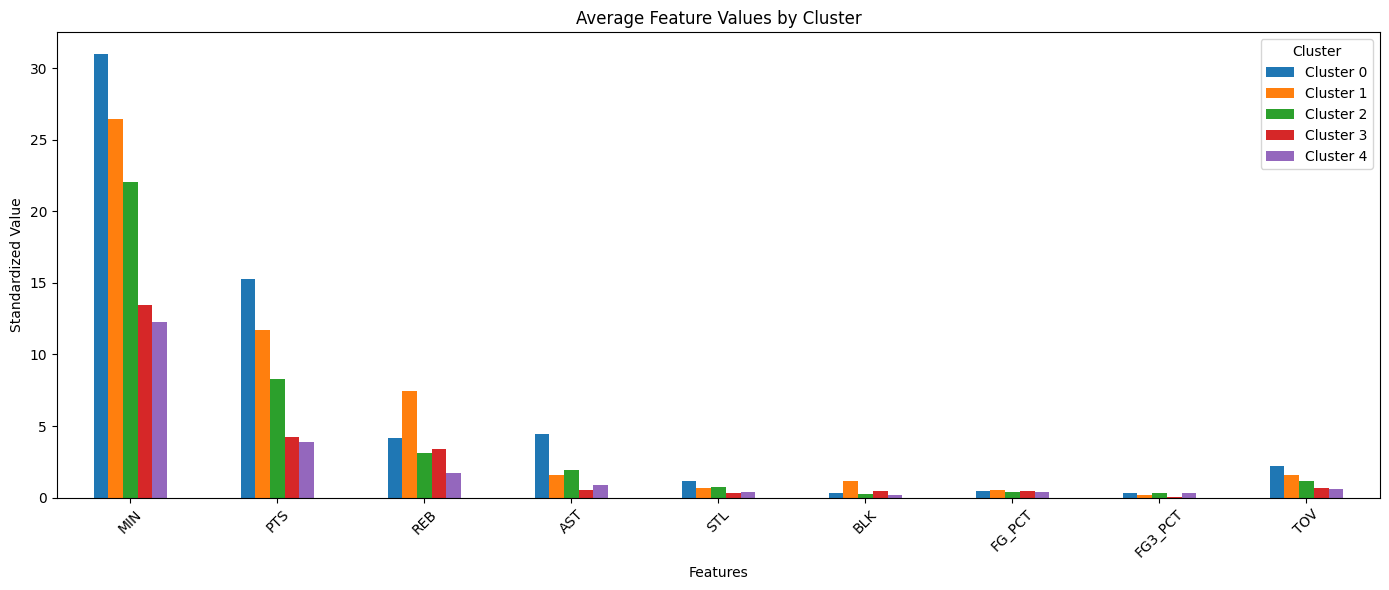

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=player_stats['Cluster'],
                     cmap='viridis',
                     alpha=0.6,
                     s=100)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('NBA Player Clusters (2000-2020)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Cluster means comparison
cluster_summary.T.plot(kind='bar', figsize=(14, 6))
plt.xlabel('Features')
plt.ylabel('Standardized Value')
plt.title('Average Feature Values by Cluster')
plt.legend(title='Cluster', labels=[f'Cluster {i}' for i in range(5)])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()